In [1]:
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

In [2]:
# 读取 .mat 文件
mat_file = r"D:\School work\10-Samples\2025.02.19_DEM+Raingauge+VARI\02.19.mat"
mat_data = scipy.io.loadmat(mat_file)

## 加载并整理输入数据

In [3]:
# 提取特征和标签
X = mat_data['X']  # 特征矩阵，包含高程、坡度、坡向、VARI 和降雨数据
y = mat_data['y']  # 标签，二分类问题，滑坡发生与否（0或1）
is_missing = mat_data['is_missing']  # 异常值指示变量

In [4]:
# 检查数据维度
print(X.shape, y.shape, is_missing.shape)

(20144, 18) (1, 20144) (20144, 18)


In [5]:
# 提取特征
rainfall = X[:, 1:14]  # 过去13天的降雨量数据（Rainfall_2 至 Rainfall_14）
elevation = X[:, 14]  # 高程（第15列）
slope = X[:, 15]  # 坡度（第16列）
aspect = X[:, 16]  # 坡向（第17列）
VARI = X[:, 17]  # VARI（第18列）

# R_today 是当天的降雨量
R_today = X[:, 0]  # 当天的降雨量是降雨数据的第一列（Rainfall_1）

In [6]:
# # 查看提取的特征形状
# print("降雨数据形状:", rainfall.shape)
# print("高程数据形状:", elevation.shape)
# print("坡度数据形状:", slope.shape)
# print("坡向数据形状:", aspect.shape)
# print("VARI数据形状:", VARI.shape)

In [7]:
# 假设土壤湿润度和摩擦力是常数（可以根据需要修改为数据驱动）
S_moist = 0.5  # 土壤湿润度（假设为常数）
mu = 0.3  # 摩擦力（假设为常数）
k = 0.9  # 衰减系数（假设为常数）

In [8]:
# 数据预处理：标准化特征数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # 标准化 X 数据

In [9]:
# is_missing 的形状为 (20144, 18)，表示每个特征的缺失指示值
X_train_with_missing = np.hstack([X_scaled, is_missing])
# 结合 `is_missing` 作为额外特征

In [10]:
# 扁平化标签，确保其为一维数组
y_train = y.flatten() 

In [11]:
# # 将 `X_train_with_missing` 和 `y_train` 转换为 Tensor 类型
X_train_tensor = torch.tensor(X_train_with_missing, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # 扁平化标签，确保其为一维数组

In [12]:
# # 将 `rainfall`、`slope` 和 `R_today` 转换为 Tensor 类型
rainfall_tensor = torch.tensor(rainfall, dtype=torch.float32)  # 降雨量数据
slope_tensor = torch.tensor(slope, dtype=torch.float32)  # 坡度
R_today_tensor = torch.tensor(R_today, dtype=torch.float32)  # 当天降雨量

In [13]:
# 划分数据集为训练集和测试集（80% 训练，20% 测试）
X_train, X_test, y_train, y_test = train_test_split(X_train_tensor, y_train_tensor, test_size=0.3, random_state=42)

## 定义模型

In [14]:
# 定义多层感知机（MLP）模型
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, depth, dropout_rate=0.1):
        super(MLP, self).__init__()
        
        # 定义网络层
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))  # 输入层
        layers.append(nn.Tanh())  # 激活函数：tanh
        layers.append(nn.Dropout(dropout_rate))  # Dropout层
        
        # 隐藏层
        for _ in range(depth):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())  # 激活函数：tanh
            layers.append(nn.Dropout(dropout_rate))  # Dropout层
        
        # 输出层
        layers.append(nn.Linear(hidden_size, output_size))  # 输出层（logits）
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.model(x)
        return x  # 在训练时返回 logits

In [15]:
# 计算有效降雨量
def effective_rainfall(R, k):
    """
    计算有效降雨量 R_e
    R: 降雨量列表（过去13天的降雨量）
    k: 衰减系数
    """
    R = torch.tensor(R, dtype=torch.float32)  # 确保 R 为 Tensor 类型
    # 根据公式计算有效降雨量 R_e
    R_e = torch.sum(R * k**torch.arange(R.shape[1], dtype=torch.float32), dim=1)  # 沿着列（降雨天数维度）求和
    return R_e

In [16]:
# 计算物理损失函数
def physics_loss(X, R, S_moist, theta, R_today, mu, k, rainfall_threshold, alpha=0.5):
    # """
    # 计算改进后的物理损失函数 f(X) = |τ(X) - μ| + α * |rainfall_factor - μ'|
    # 其中 τ(X) = R_e * S_moist * theta * R_today
    # rainfall_factor 是降雨对滑坡的影响因子
    # """
    # 将 R_today 转换为 Tensor 类型（确保一致性）
    R_today_tensor = torch.tensor(R_today, dtype=torch.float32)  # 确保 R_today 为 Tensor 类型
    
    # 计算有效降雨量
    R_e = effective_rainfall(R, k)  # 计算有效降雨量
    tau = R_e * S_moist * theta * R_today_tensor  # 计算驱动力
    
    # 降雨影响因子：如果当天的降雨量大于某个阈值，滑坡发生的概率增加
    rainfall_factor = torch.where(R_today_tensor > rainfall_threshold, torch.tensor(1.5), torch.tensor(1.0))
    
    # 土壤湿润度和地形因子对滑坡的影响
    terrain_loss = torch.abs(rainfall_factor - mu)  # 降雨影响的损失
    
    # 总物理损失
    total_loss = torch.abs(tau - mu) + alpha * terrain_loss  # 加权组合
    return total_loss.mean()  # 返回平均物理损失

In [17]:
# 定义总损失函数：数据损失 + 物理损失
def total_loss(model, X_train, y_train, R, S_moist, theta, R_today, mu, k, rainfall_threshold, lambda_phy=0.1, alpha=0.5):
    # 数据损失：二分类交叉熵损失
    criterion = nn.BCEWithLogitsLoss()
    outputs = model(X_train)
    data_loss = criterion(outputs.squeeze(), y_train)
    
    # 物理损失
    phy_loss = physics_loss(X_train, R, S_moist, theta, R_today, mu, k, rainfall_threshold, alpha)
    
    # 总损失：数据损失 + 物理损失
    total = data_loss + lambda_phy * phy_loss
    return total

In [18]:
# 创建多层感知机模型实例
input_size = X_train_with_missing.shape[1]  # 特征数量（包括 is_missing）
hidden_size = 64  # 隐藏层节点数
output_size = 1  # 输出一个预测值
depth = 3  # 隐藏层数量
dropout_rate = 0.1  # Dropout层的丢弃率

# 初始化模型
mlp_model = MLP(input_size, hidden_size, output_size, depth, dropout_rate)

In [19]:
# 定义优化器，并加入 L2 正则化的 weight_decay
learning_rate = 1e-3
lambda_l2 = 0.01  # 设置 L2 正则化强度
optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

In [20]:
# 训练模型
def train(model, X_train, y_train, R, S_moist, theta, R_today, mu, k, rainfall_threshold, epochs=1000, lambda_phy=0.1):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # 计算总损失
        loss = total_loss(model, X_train, y_train, R, S_moist, theta, R_today, mu, k, rainfall_threshold, lambda_phy)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f"{epoch}, {loss.item():.6f}")

In [21]:
# 下面这行是使用全部输入数据来训练模型的指令
# train(mlp_model, X_train_with_missing, y.flatten())  # 扁平化 y，确保其是一个一维数组

## 设置训练集和测试集
    后续使用测试集的测试效果反映模型性能

In [22]:
# # 确保所有输入数据是 Tensor 类型
# print(f"X_train type: {type(X_train_with_missing_tensor)}")  # 应该是 <class 'torch.Tensor'>
# print(f"y_train type: {type(y_train)}")  # 应该是 <class 'torch.Tensor'>
# print(f"rainfall type: {type(rainfall)}")  # 应该是 <class 'torch.Tensor'>
# print(f"S_moist type: {type(S_moist)}")  # 应该是 <class 'torch.Tensor'>
# print(f"slope type: {type(slope)}")  # 应该是 <class 'torch.Tensor'>
# print(f"R_today type: {type(R_today)}")  # 应该是 <class 'torch.Tensor'>
# print(f"mu type: {type(mu)}")  # 应该是 <class 'torch.Tensor'>
# print(f"k: {type(k)}")  # 应该是 <class 'torch.Tensor'>

In [23]:
# 训练模型
train(mlp_model, X_train, y_train, rainfall, S_moist, slope, R_today, mu, k, rainfall_threshold=20.0, epochs=2100, lambda_phy=0.1)

0, 0.756804
10, 0.657365
20, 0.515166
30, 0.495841
40, 0.492394
50, 0.486722
60, 0.484702
70, 0.481849
80, 0.480705
90, 0.481739
100, 0.479674
110, 0.479044
120, 0.478441
130, 0.478157
140, 0.475556
150, 0.475181
160, 0.473284
170, 0.469939
180, 0.470808
190, 0.468510
200, 0.465746
210, 0.464906
220, 0.463648
230, 0.462135
240, 0.460255
250, 0.459544
260, 0.458783
270, 0.459622
280, 0.457408
290, 0.456150
300, 0.457596
310, 0.455908
320, 0.455491
330, 0.454416
340, 0.453885
350, 0.452978
360, 0.450984
370, 0.452259
380, 0.450479
390, 0.451635
400, 0.449868
410, 0.450126
420, 0.450797
430, 0.447596
440, 0.447539
450, 0.447549
460, 0.444956
470, 0.446680
480, 0.445713
490, 0.444535
500, 0.443004
510, 0.440653
520, 0.442300
530, 0.440244
540, 0.442553
550, 0.440041
560, 0.440274
570, 0.439155
580, 0.437783
590, 0.436875
600, 0.437117
610, 0.435684
620, 0.436605
630, 0.435825
640, 0.431878
650, 0.433022
660, 0.433467
670, 0.432119
680, 0.430049
690, 0.430085
700, 0.427719
710, 0.426230
720

In [24]:
# 预测并计算不确定性：MC Dropout 预测
def predict_with_uncertainty(model, X, n_samples=100):
    model.train()  # 在训练模式下启用 Dropout
    predictions = np.zeros((n_samples, X.shape[0]))  # 存储每次前向传播的结果
    
    # 多次前向传播获取预测分布
    for i in range(n_samples):
        predictions[i] = model(torch.tensor(X, dtype=torch.float32)).detach().numpy().squeeze()

    # 计算预测的均值和标准差
    mean_prediction = predictions.mean(axis=0)  # 均值
    std_prediction = predictions.std(axis=0)    # 标准差

    return mean_prediction, std_prediction

In [25]:
# 对新样本进行预测并计算不确定性
mean_pred, std_pred = predict_with_uncertainty(mlp_model, X_train_with_missing, n_samples=100)

In [26]:
# 可视化预测结果和不确定性
def plot_uncertainty(mean_pred, std_pred):
    plt.plot(mean_pred, label='Mean Prediction')
    plt.fill_between(range(len(mean_pred)), mean_pred - 2*std_pred, mean_pred + 2*std_pred, color='gray', alpha=0.5)
    plt.legend()
    plt.show()

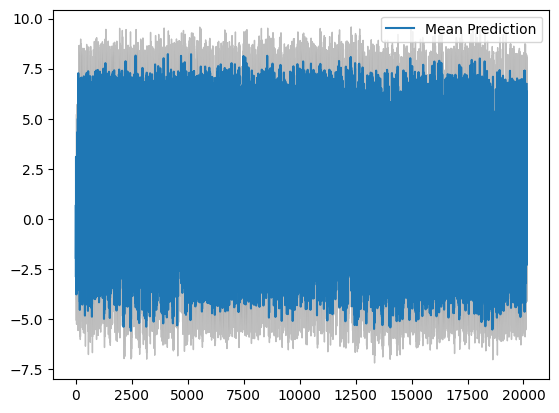

In [27]:
# 可选：可视化模型预测与不确定性
plot_uncertainty(mean_pred, std_pred)

In [28]:
# # 保存训练好的模型
torch.save(mlp_model.state_dict(), '2025.02.25_PINNs_MCoutput.pth')

## 评估模型性能

In [29]:
# 用模型预测测试集
mlp_model.eval()
with torch.no_grad():
    # 如果 X_test 是 Tensor，直接使用它，或者 clone().detach() 来确保不跟计算图相关
    predictions = mlp_model(X_test.clone().detach()).squeeze()  # 使用 clone().detach()
    predictions_classitied = (predictions > 0.5).numpy()  # 将预测结果转化为 0 或 1（分类）

In [30]:
# 计算准确率
accuracy = accuracy_score(y_test, predictions_classitied)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 82.56%


In [31]:
# 计算混淆矩阵
cm = confusion_matrix(y_test, predictions_classitied)
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[2730  298]
 [ 756 2260]]


In [32]:
# 计算精确度与召回率
# 精确度（Precision）：衡量所有被预测为正类的样本中，实际为正类的比例。
# 公式为：Precision = TP / (TP + FP)。
# 召回率（Recall）：衡量所有实际为正类的样本中，模型正确预测为正类的比例。
# 公式为：Recall = TP / (TP + FN)。

precision = precision_score(y_test, predictions_classitied)
recall = recall_score(y_test, predictions_classitied)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.8835
Recall: 0.7493


In [33]:
# F1 分数是精确度和召回率的调和平均数，常用于类不平衡的情况下，衡量模型的综合性能。
# 公式为：F1 = 2 * (Precision * Recall) / (Precision + Recall)。
f1 = f1_score(y_test, predictions_classitied)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8109


In [34]:
# 计算 AUC
# ROC（接收者操作特征）曲线展示了模型在不同分类阈值下的表现。
# AUC（曲线下面积）是该曲线下的面积，值越接近 1，说明模型的表现越好。
auc_score = roc_auc_score(y_test, predictions)
print(f"AUC: {auc_score:.4f}")

AUC: 0.8944


In [35]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predictions)

In [36]:
# 计算 AUC（曲线下面积）
roc_auc = auc(fpr, tpr)

In [37]:
# 将 ROC 曲线数据保存为 CSV 文件
roc_data = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds
})
roc_csv_file = 'roc_Fs.csv'  # 可根据模型名称调整文件名
roc_data.to_csv(roc_csv_file, index=False)
print(f"ROC curve data saved to {roc_csv_file}")


ROC curve data saved to roc_Fs.csv


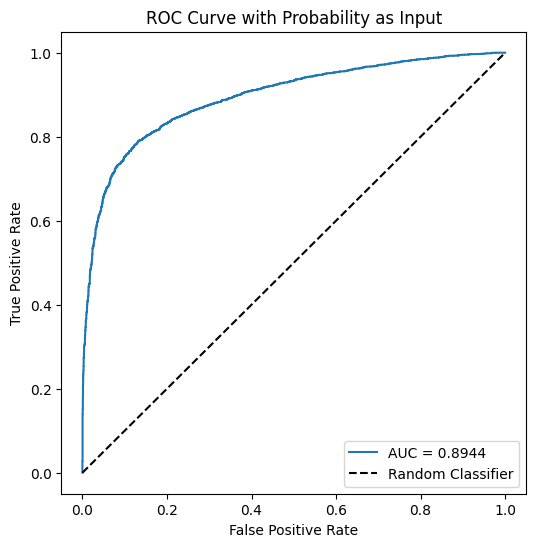

In [38]:
# 绘制 ROC 曲线
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # 随机分类器的对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Probability as Input')
plt.legend(loc='lower right')
plt.show()

In [39]:
# # 对 logits 进行 Sigmoid 激活处理，转换为概率值
# y_pred_prob = torch.sigmoid(y_pred_prob)

# # 打印转换后的概率值
# print(y_pred_prob[:10])  # 查看转换后的概率值

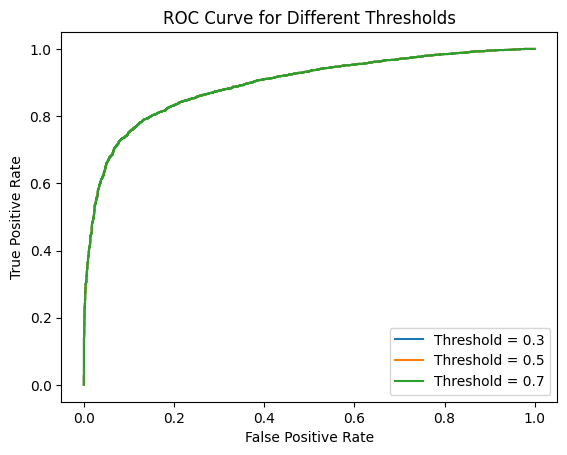

In [40]:
# 手动设置不同的阈值
thresholds = [0.3, 0.5, 0.7]  # 设置不同的阈值

for threshold in thresholds:
    # # 使用 PyTorch 的 .int() 方法进行类型转换
    # y_pred_binary = (predictions > threshold).int()  # 将概率转换为二分类标签
    # 这里将概率转换为二分类标签的做法是错误的，绘制ROC曲线需要直接输入概率值
    
    # 计算 ROC 曲线
    fpr, tpr, _ = roc_curve(y_test, predictions.numpy())  # 将 Tensor 转为 NumPy 数组
    
    # 绘制 ROC 曲线
    plt.plot(fpr, tpr, label=f'Threshold = {threshold}')

# 显示 ROC 曲线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Thresholds')
plt.legend(loc='lower right')
plt.show()
